In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

torch.autograd.set_detect_anomaly(True)

batch_size = 1024
dataset = "MNIST"
#dataset = "CIFAR10"
#dataset = "CIFAR100"

if(dataset == "MNIST"):
    # 1) MNIST Dataset & Dataloaders
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'sis', 'seven', 'eight', 'nine')

    input_size = (1, 32, 32)

if(dataset == "CIFAR10"):
    # 2) CIFAR-10 dataset
    train_transform = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BILINEAR),
        #transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2470, 0.2435, 0.2616))  # mean, std
    ])

    # Transformations for testing: just convert and normalize
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2470, 0.2435, 0.2616))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    input_size = (3, 32, 32)

if(dataset == "CIFAR100"):
    # 2) CIFAR-10 dataset
    train_transform = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BILINEAR),
        #transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2470, 0.2435, 0.2616))  # mean, std
    ])

    # Transformations for testing: just convert and normalize
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2470, 0.2435, 0.2616))
    ])

    train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

    classes = [x for x in range(100)]

    input_size = (3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


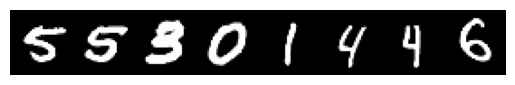

In [2]:
def imshow(img_tensor):
    """
    img_tensor: a batch of images in shape (B, C, H, W) or a single image in (C, H, W).
    """
    # If it's a batch of images (4D), make a grid first
    if len(img_tensor.shape) == 4:
        img_tensor = torchvision.utils.make_grid(img_tensor)
    # Unnormalize
    #img_tensor = unnormalize(img_tensor)
    # Convert to numpy
    npimg = img_tensor.numpy()
    # Transpose from (C, H, W) to (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[:8])

In [3]:
def param_to_bit(x : torch.Tensor) -> torch.Tensor:
    return torch.exp(x)

def bit_to_param(x : torch.Tensor) -> torch.Tensor:
    return torch.log(x)

In [4]:
def fake_float_truncate(x: torch.Tensor, e_bits: int, m_bits: int, s: int) -> torch.Tensor:
    """
    Approximate 'float' with e_bits exponent bits and m_bits mantissa bits.
    Simplified approach: unbiased exponent in integer range + truncated mantissa.
    """
    
    sign = x.sign()
    abs_x = x.abs().clamp(min=1e-45)

    exponent = torch.floor(torch.log2(abs_x))
    mantissa = abs_x / (2**exponent)
    
    #assert(mantissa >= 1.0 and mantissa <= 2.0)

    #for 2 bits (0  3), the midpoint shoud be in 1.5
    #for 1 bit (0 - 1) the mid point shoud be in 0.5
    #for 0 bits, the midpoint is zero
    exponent_s = exponent - s
    exponent_midi = (2**e_bits - 1)/2
    exponent_n = exponent_s + exponent_midi

    # truncate exponent
    exponent_n_trunc = torch.clip(exponent_n, 0, 2**e_bits - 1)
    exponent_d_trunc = exponent_n_trunc - exponent_midi
        
    # truncate mantissa
    mantissa_n = mantissa - 1
    m_scale = 2.0 ** m_bits
    mantissa_trunc = torch.floor(mantissa_n * m_scale) / m_scale
    
    x_trunc = sign * (2**exponent_d_trunc) * mantissa_trunc * (2**s)
    
    #if(m_bits == 0 and x_trunc.any()):
    #    print("bits: ", e_bits, " ", m_bits, " ", s)
    #    print("x: ", x)
    #    print("mantissa: ", mantissa)
    #    print("exponent: ", exponent)
    #    print("mantissa_n: ", mantissa_n)
    #    print("mantissa_trunc: ", mantissa_trunc)
    #    print("exponent s: ", exponent_s)
    #    print("exponent mid: ", exponent_midi)
    #    print("exponent_normalized: ", exponent_n)
    #    print("exponent_trunc: ", exponent_n_trunc)
    #    print("x_trunc: ", x_trunc)
    
    return x_trunc

class FakeFloatFunction(torch.autograd.Function):
    """
    Custom autograd for 'fake-float' exponent+mantissa truncation.
    """
    @staticmethod
    def forward(ctx, x, e_bits_param, m_bits_param, s_param):
        
        # save for backward
        ctx.save_for_backward(x, e_bits_param, m_bits_param, s_param)
        
        # Round e_bits, m_bits to nearest integer for the forward pass
        e_bits_int = int(torch.round(param_to_bit(e_bits_param)).item())
        m_bits_int = int(torch.round(param_to_bit(m_bits_param)).item())
        s_int = int(torch.round(s_param).item())

        out = fake_float_truncate(x, e_bits_int, m_bits_int, s_int)
        
        return out

    @staticmethod
    def backward(ctx, grad_output):
        x, e_bits_param, m_bits_param, s_param = ctx.saved_tensors
        
        e_bits = param_to_bit(e_bits_param)
        m_bits = param_to_bit(m_bits_param)
        s = s_param
                
        e_bits_int = int(torch.round(e_bits).item())
        m_bits_int = int(torch.round(m_bits).item())
        s_int = int(torch.round(s).item())

        #print("shape x: ", x.shape)
        #print("shape grad_output: ", grad_output.shape)

        # 1) Gradient wrt x: straight-through
        grad_x = grad_output
        
        # 1) Gradient wrt x: approximate with central difference
        """
        grad_x = None
        if True:
            delta = 0.01            

            f_plus2  = fake_float_truncate(x + 2.0*delta, e_bits_int, m_bits_int, s_int)
            f_plus   = fake_float_truncate(x + 1.0*delta, e_bits_int, m_bits_int, s_int)
            f_minus  = fake_float_truncate(x - 1.0*delta, e_bits_int, m_bits_int, s_int)
            f_minus2 = fake_float_truncate(x - 2.0*delta, e_bits_int, m_bits_int, s_int)
        
            der = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) / (12.0 * delta)
            grad_x = grad_output * der
        """
                
        # 2) Gradient wrt e_bits: approximate with central difference
        grad_e_bits = None
        if e_bits_param.requires_grad:
            
            if(e_bits_int < 2):
                f_plus   = fake_float_truncate(x, e_bits_int + 1, m_bits_int, s_int)
                f_minus  = fake_float_truncate(x, e_bits_int    , m_bits_int, s_int)
                der = (f_plus - f_minus)
            else:
                f_plus2  = fake_float_truncate(x, e_bits_int + 2, m_bits_int, s_int)
                f_plus   = fake_float_truncate(x, e_bits_int + 1, m_bits_int, s_int)
                f_minus  = fake_float_truncate(x, e_bits_int - 1, m_bits_int, s_int)
                f_minus2 = fake_float_truncate(x, e_bits_int - 2, m_bits_int, s_int)
            
                der = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) / 12.0
            
            grad_e_bits = grad_output * der * e_bits
        
        # 3) Gradient wrt m_bits: approximate with central difference
        grad_m_bits = None
        if m_bits_param.requires_grad:
            
            if(m_bits_int < 2):
                f_plus   = fake_float_truncate(x, e_bits_int, m_bits_int + 1, s_int)
                f_minus  = fake_float_truncate(x, e_bits_int, m_bits_int    , s_int)
                der = (f_plus - f_minus)
            else:
                f_plus2  = fake_float_truncate(x, e_bits_int, m_bits_int + 2, s_int)
                f_plus   = fake_float_truncate(x, e_bits_int, m_bits_int + 1, s_int)
                f_minus  = fake_float_truncate(x, e_bits_int, m_bits_int - 1, s_int)
                f_minus2 = fake_float_truncate(x, e_bits_int, m_bits_int - 2, s_int)
            
                der = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) / 12.0
            
            grad_m_bits = grad_output * der * m_bits
       
        # 4) Gradient wrt m_bits: approximate with central difference
        grad_s_bits = None
        if s_param.requires_grad:
            
            f_plus2  = fake_float_truncate(x, e_bits_int, m_bits_int, s_int + 2)
            f_plus   = fake_float_truncate(x, e_bits_int, m_bits_int, s_int + 1)
            f_minus  = fake_float_truncate(x, e_bits_int, m_bits_int, s_int - 1)
            f_minus2 = fake_float_truncate(x, e_bits_int, m_bits_int, s_int - 2)
            
            der = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) / 12.0 
            grad_s_bits = grad_output * der
             
        return grad_x, grad_e_bits, grad_m_bits, grad_s_bits

### differentiable Round

In [5]:
class RoundSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: use the usual rounding
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass: pass the gradient unchanged (STE)
        return grad_output
    
class RoundFDE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: use the usual rounding
        ctx.save_for_backward(input)
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass: pass the gradient unchanged (STE)
        (input, ) = ctx.saved_tensors
        delta = 1.0
        f_plus2  = torch.round(input + 2*delta)
        f_plus   = torch.round(input + 1*delta)
        f_minus  = torch.round(input - 1*delta)
        f_minus2 = torch.round(input - 2*delta)
        # der = (f_plus - f_minus)/2.0
        der = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) / (12.0 * delta)
        
        return der * grad_output

class RoundSIG(torch.autograd.Function):
    """
    Custom autograd function that does a hard round in forward,
    but uses a sigmoid-based approximation for the backward pass.
    """

    @staticmethod
    def forward(ctx, input, alpha=10.0):
        """
        Forward pass: returns torch.round(input).
        """
        ctx.save_for_backward(input)
        ctx.alpha = alpha
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass: approximate the gradient of round(x)
        with the derivative of a sigmoid centered at the fractional midpoint (0.5).
        """
        (input,) = ctx.saved_tensors
        alpha = ctx.alpha

        # Fractional part
        frac = input - torch.floor(input)

        # Sigmoid of (fractional_part - 0.5), scaled by alpha
        s = torch.sigmoid(alpha * (frac - 0.5))

        # Derivative of sigmoid = alpha * s * (1 - s)
        grad_input = alpha * s * (1 - s) * grad_output
        return grad_input, None  # alpha is not a tensor that requires grad
    
def diff_round(x):
    #return RoundSTE.apply(x)
    return RoundFDE.apply(x)
    #return RoundSIG.apply(x)

### Differentiable Floor

In [6]:
class FloorSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass uses standard floor
        return torch.floor(input)

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through pass: just return the gradient as-is
        return grad_output

class FloorFDE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: use the usual rounding
        ctx.save_for_backward(input)
        return torch.floor(input)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass: pass the gradient unchanged (STE)
        (input, ) = ctx.saved_tensors
        delta = 1.0
        f_plus2  = torch.floor(input + 2*delta)
        f_plus   = torch.floor(input + 1*delta)
        f_minus  = torch.floor(input - 1*delta)
        f_minus2 = torch.floor(input - 2*delta)
        # der = (f_plus - f_minus)/2.0
        der = (-f_plus2 + 8*f_plus - 8*f_minus + f_minus2) / (12.0 * delta)
        
        return der * grad_output

def diff_floor(input):
    #return FloorSTE.apply(input)
    return FloorFDE.apply(input)

### Observers

In [7]:
class MinMaxObserver(nn.Module):
    def __init__(self):
        super().__init__()
        # We store running min/max
        self.register_buffer("min_val", torch.tensor(float("inf")))
        self.register_buffer("max_val", torch.tensor(float("-inf")))
        # You could also store averaging stats, etc.

    def forward(self, x):
        # Update running min/max
        self.min_val = torch.min(self.min_val, x.detach().min())
        self.max_val = torch.max(self.max_val, x.detach().max())
        return x  # Just pass through

### Fixed point quanizers

In [ ]:
class FixedPointFakeQuantize(nn.Module):
    def __init__(self, observer, bits=32, requires_grad=False):
        super().__init__()
        self.observer = observer
        self.bits = nn.Parameter(torch.tensor(float(bits)), requires_grad=requires_grad)

    def forward(self, x):
        
        b_int = torch.clamp(diff_round(self.bits), 1, 32)
        
        # 1) Get min/max from observer
        min_val = self.observer.min_val
        max_val = self.observer.max_val

        # If they're not valid, skip
        #if min_val >= max_val:
        #    return x

        # 2) Compute scale and zero_point
        # For an unsigned 4-bit range, we can hold values 0..15
        # qmin, qmax = 0, (1 << b_int) - 1  # e.g. 0..15
        qmin, qmax = torch.tensor(float(0)), 2**b_int - 1  # e.g. 0..15
        
        qmin = qmin.to(x.device)
        #qmax = qmax.to(x.device)
        max_val = max_val.to(x.device)
        min_val = min_val.to(x.device)

        # Typical formula for scale/zero-point:
        scale = (max_val - min_val) / float(qmax - qmin)
        zero_point = qmin - diff_round(min_val / scale)

        # 3) Quantize (in floating point)
        # clamp to range of [qmin, qmax]
        q_x = torch.clamp(diff_round(x / scale + zero_point), qmin, qmax)

        # 4) Dequantize back to float
        fq_x = (q_x - zero_point) * scale
        return fq_x

class FixedPointFakeQuantize2(nn.Module):
    def __init__(self, bits=32, requires_grad=False):
        super().__init__()
        self.bits = nn.Parameter(torch.tensor(float(bits)), requires_grad=requires_grad)
        self.scale = nn.Parameter(torch.tensor(float(0)), requires_grad=requires_grad)
        self.zero_point = nn.Parameter(torch.tensor(float(0)), requires_grad=requires_grad)

    def forward(self, x):
        
        bits_int = torch.clamp(diff_round(self.bits), 1, 32)
        scale_int = diff_round(self.scale)
        zero_point_int = diff_round(self.zero_point)
        
        qmin = torch.tensor(float(0)).to(x.device)
        qmax = 2**bits_int - 1  # e.g. 0..15
        
        #from float to fixed point, and quantize accordingly
        q_x = torch.clamp(diff_round(x / 2**scale_int + zero_point_int), qmin, qmax)

        # from quantized fixed point to float
        fq_x = (q_x - zero_point_int) * 2**scale_int
        return fq_x

    def getBits(self):
        return [self.bits]

    def printParams(self):
        print("bits: ", self.bits.detach().item())
        print("scale: ", self.scale.detach().item())
        print("zero point: ", self.zero_point.detach().item())

### Floating point quantizers

In [9]:
class FloatingPointFakeQuantize(nn.Module):
    def __init__(self, m_bits=23, e_bits=8, requires_grad=False):
        super().__init__()
        self.e_bits = nn.Parameter(torch.tensor(float(e_bits)), requires_grad=requires_grad)
        self.m_bits = nn.Parameter(torch.tensor(float(m_bits)), requires_grad=requires_grad)
        self.scale = nn.Parameter(torch.tensor(float(0)), requires_grad=requires_grad)

    def forward(self, x):

        e_bits_int = torch.clamp(diff_round(self.e_bits), 0, 32)
        m_bits_int = torch.clamp(diff_round(self.m_bits), 1, 32)
        scale_int = diff_round(self.scale)
        
        sign = x.sign()
        abs_x = x.abs().clamp(min=1e-45)

        #recover the floatint point representation
        #exponent \in {-2**7,..,2**7-1}
        #mantissa \in {1.0,...,2.0}

        exponent = diff_floor(torch.log2(abs_x)).clamp(min=1e-45)
        mantissa = abs_x / (2**exponent)
    
        # truncate exponent
        # lets parameterize the exponent as a constant value + a variable value
        # the constant part is 2**7-1 in standar floating point, but we will learn it
        # the variable part \in {0,..,2**8-1}
        # lets say exponent = v_exponent - 2**(bits-1)-1 + c_exponent
        # so v_exponent = exponent + 2**(bits-1)-1 - c_exponent
        c_exponent = scale_int
        v_exponent = exponent + (2**(e_bits_int-1)-1) - c_exponent
        
        # the valriable part is clamped to the alloted bits
        q_min = torch.tensor(float(0)).to(x.device)
        q_max = 2**e_bits_int-1
        q_exponent = torch.clamp(v_exponent, q_min, q_max) - (2**(e_bits_int-1)-1) + c_exponent
    
        # truncate mantissa
        # this just removes the less significant bits
        m_scale = 2.0 ** m_bits_int
        q_mantissa = diff_floor(mantissa * m_scale) / m_scale
    
        # from quantized floatint point to float
        fq_x = sign * (2**q_exponent) * q_mantissa
        return fq_x

    def getBits(self):
        return [self.e_bits, self.m_bits]

    def printParams(self):
        print("e_bits: ", self.e_bits.detach().item())
        print("m_bits: ", self.m_bits.detach().item())
        print("scale: ", self.scale.detach().item())

### Float32 example model

In [10]:
class SimpleCIFAR10Model(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size[0], 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * input_size[1]//8 * input_size[2]//8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = self.fc3(x)
        return x

### Quantized example model

In [11]:
class QuantWrapper(nn.Module):
    def __init__(self, module, optimizeQuant=False):
        super().__init__()
        self.module = module
        #self.observer = MinMaxObserver()
        #self.fake_quant = FixedPointFakeQuantize(self.observer, requires_grad=optimizeQuant)
        #self.fake_quant = FixedPointFakeQuantize2(requires_grad=optimizeQuant)
        self.fake_quant_input = FloatingPointFakeQuantize(requires_grad=optimizeQuant)
        self.fake_quant_weight = FloatingPointFakeQuantize(requires_grad=optimizeQuant)
    
    def forward(self, x):
        #x = self.observer(x)
        x = self.fake_quant_input(x)
        w = self.fake_quant_weight(self.module.weight)
        b = self.module.bias
        if isinstance(self.module, nn.Conv2d):
            return F.conv2d(x, w, b, stride=self.module.stride, padding=self.module.padding, dilation=self.module.dilation, groups=self.module.groups)
        elif isinstance(self.module, nn.Linear):
            return F.Linear(x, w, b)
        else:
            return self.module(x)
        
    def getBits(self):
        return self.fake_quant_input.getBits() + self.fake_quant_weight.getBits()
        #return self.fake_quant_weight.getBits()
    
    def printQuantParams(self):
        print("input quant params: ")
        self.fake_quant_input.printParams()
        print("weight quant params: ")
        self.fake_quant_weight.printParams()

class QuantSimpleCIFAR10Model(nn.Module):
    def __init__(self, num_classes=10, optimizeQuant=False):
        super().__init__()
        self.conv1 = QuantWrapper(nn.Conv2d(input_size[0], 32, kernel_size=3, padding=1, bias=False), optimizeQuant=optimizeQuant)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = QuantWrapper(nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False), optimizeQuant=optimizeQuant)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = QuantWrapper(nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False), optimizeQuant=optimizeQuant)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = QuantWrapper(nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False), optimizeQuant=optimizeQuant)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = QuantWrapper(nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False), optimizeQuant=optimizeQuant)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = QuantWrapper(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False), optimizeQuant=optimizeQuant)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * input_size[1]//8 * input_size[2]//8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
def bitwidth_squared(model):
    s = 0.0
    for name, module in model.named_modules():
        if isinstance(module, QuantWrapper):
            for bit in module.getBits():
                s += bit ** 2
    return s

In [13]:
def printBitWidths(model):
    for name, module in model.named_modules():
        if isinstance(module, QuantWrapper):
            print("module: ", name)
            module.printQuantParams()

In [14]:
def train(model, device, train_loader, optimizer, epoch, lambda_bw=1.0e-3):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss_ce = F.cross_entropy(output, target)
        penalty_bw = bitwidth_squared(model) 
        #penalty_bw = bitwidth_sum(model) 
        loss = loss_ce + lambda_bw*penalty_bw
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        #if batch_idx % 200 == 0:
        #    print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
        #          f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    
    train_loss /= len(train_loader)
    print(f"Train set: Average loss: {train_loss:.4f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy} ({100.0*accuracy:.2f}%)")
    return accuracy

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("using divice ", device)

best_model_path = f"train_weights_and_quant_{dataset}_best_model.pth"
quant_model_path = f"train_weights_and_quant_{dataset}_quant_model.pth"

load_model_path = None
save_model_path = best_model_path

if(os.path.isfile(quant_model_path)):
    load_model_path = quant_model_path
    save_model_path =quant_model_path
elif(os.path.isfile(best_model_path)):
    load_model_path = best_model_path   
    save_model_path = quant_model_path
    
if(load_model_path):
    # Create model
    # model = SimpleQuantizedMLP(e_bits=4.0, m_bits=4.0, num_classes=len(classes)).to(device)
    model = QuantSimpleCIFAR10Model(num_classes=len(classes), optimizeQuant=True).to(device)
    #model = SimpleCIFAR10Model(num_classes=len(classes)).to(device)
    model.load_state_dict(torch.load(quant_model_path, weights_only=True))
else:
    model = QuantSimpleCIFAR10Model(num_classes=len(classes), optimizeQuant=False).to(device)

# Create optimizer (SGD or Adam)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_accuracy = 0.0
# Train for some epochs
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        torch.save(model.state_dict(), save_model_path)
        
    printBitWidths(model)

using divice  cuda
Train set: Average loss: 7.1140
Test set: Average loss: 0.0184, Accuracy: 0.994 (99.40%)
module:  conv1
input quant params: 
e_bits:  7.941058158874512
m_bits:  22.94096565246582
scale:  0.0
weight quant params: 
e_bits:  7.941058158874512
m_bits:  22.941030502319336
scale:  0.0
module:  conv2
input quant params: 
e_bits:  7.941058158874512
m_bits:  22.94104766845703
scale:  0.0
weight quant params: 
e_bits:  7.941058158874512
m_bits:  22.94103240966797
scale:  0.0
module:  conv3
input quant params: 
e_bits:  7.941058158874512
m_bits:  22.940954208374023
scale:  0.0
weight quant params: 
e_bits:  7.941058158874512
m_bits:  22.94103240966797
scale:  0.0
module:  conv4
input quant params: 
e_bits:  7.941058158874512
m_bits:  22.940996170043945
scale:  0.0
weight quant params: 
e_bits:  7.941058158874512
m_bits:  22.94103240966797
scale:  0.0
module:  conv5
input quant params: 
e_bits:  7.941058158874512
m_bits:  22.940929412841797
scale:  0.0
weight quant params: 
e_bi